In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential, ReduceLROnPlateau # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [2]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['TPB']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2018-04-19,9.51,32.45,7295110,242206000000,0,0,35.00,35.00,31.80,0.45,1.41
1,2018-05-03,8.73,29.80,407660,12007000000,0,0,29.80,29.80,29.00,0.00,0.00
2,2018-05-14,8.65,29.50,252920,7415000000,0,0,29.80,29.80,28.80,-0.30,-1.01
3,2018-05-18,8.71,29.70,465950,13747000000,0,0,29.40,29.80,29.15,0.20,0.68
4,2018-05-23,8.62,29.40,506080,14801000000,0,0,29.30,29.45,28.90,0.10,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...
1664,2024-12-17,16.20,16.20,4265400,69097000000,475002,7678280200,16.20,16.30,16.15,0.00,0.00
1665,2024-12-13,16.25,16.25,4585600,74864000000,450004,7315061000,16.35,16.45,16.25,-0.10,-0.61
1666,2024-12-18,16.25,16.25,5405700,87461000000,1,15100,16.20,16.30,16.10,0.05,0.31
1667,2024-12-19,16.00,16.00,10785400,173039000000,450003,7287345450,16.05,16.15,15.95,-0.25,-1.54


In [3]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               1669 non-null   object 
 1   GiaDieuChinh       1669 non-null   float64
 2   GiaDongCua         1669 non-null   float64
 3   KhoiLuongKhopLenh  1669 non-null   int64  
 4   GiaTriKhopLenh     1669 non-null   int64  
 5   KLThoaThuan        1669 non-null   int64  
 6   GtThoaThuan        1669 non-null   int64  
 7   GiaMoCua           1669 non-null   float64
 8   GiaCaoNhat         1669 non-null   float64
 9   GiaThapNhat        1669 non-null   float64
 10  ThayDoi_GiaTri     1669 non-null   float64
 11  ThayDoi_PhanTram   1669 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 156.6+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,1669.000000,1669.000000,1.669000e+03,1.669000e+03,1.669000e+03,1.669000e+03,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,11.705698,24.796675,4.207516e+06,1.010046e+11,8.403488e+05,2.011887e+10,24.803805,25.139275,24.436189,-0.010449,-0.025914
std,4.257971,7.253694,5.730625e+06,1.255270e+11,2.137545e+06,5.549473e+10,7.253337,7.417967,7.103639,0.582887,2.119157
min,5.160000,15.250000,1.285000e+04,2.730000e+08,0.000000e+00,0.000000e+00,15.300000,15.400000,15.150000,-6.950000,-27.150000
25%,7.320000,19.650000,3.726400e+05,8.787000e+09,0.000000e+00,0.000000e+00,19.500000,20.000000,19.200000,-0.200000,-0.850000
50%,12.150000,22.600000,2.544400e+06,6.138800e+10,0.000000e+00,0.000000e+00,22.600000,22.850000,22.350000,0.000000,0.000000
75%,14.840000,27.300000,5.651400e+06,1.427020e+11,3.850000e+05,7.910000e+09,27.500000,27.800000,27.000000,0.200000,0.840000
max,22.570000,52.000000,6.082060e+07,1.017000e+12,2.298000e+07,1.027840e+12,52.700000,53.500000,51.200000,3.200000,6.980000


In [4]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

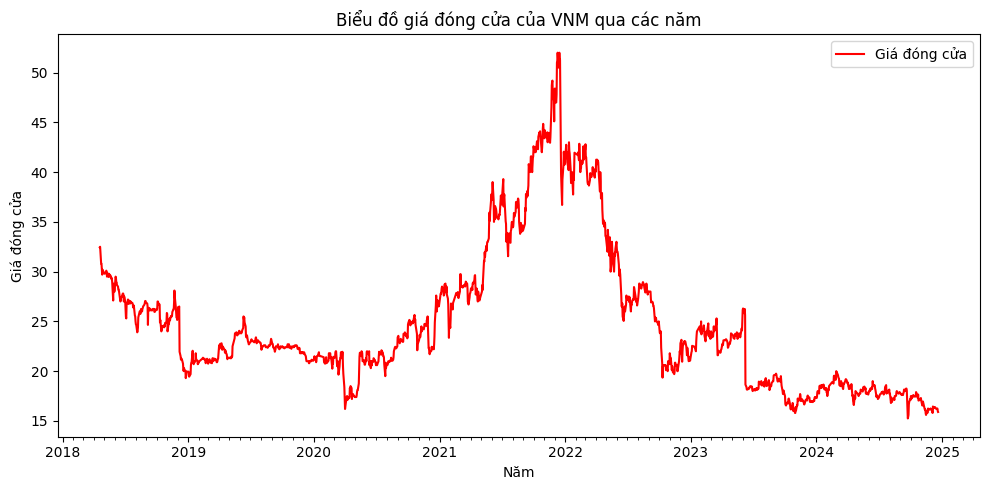

In [5]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [6]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [7]:
df1

,GiaDongCua
Ngay,
2018-04-19,32.45
2018-04-20,32.50
2018-04-23,30.80
2018-04-24,30.80
2018-04-26,29.70
...,...
2024-12-16,16.20
2024-12-17,16.20
2024-12-18,16.25


In [8]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [9]:
data

array([[32.45],
       [32.5 ],
       [30.8 ],
       ...,
       [16.25],
       [16.  ],
       [15.9 ]])

In [10]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [11]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Epoch 1/100


C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.12585, saving model to save_models/TPB_model_adjusted.keras
11/11 - 5s - 477ms/step - loss: 0.2325 - val_loss: 0.1258 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 0.12585 to 0.10058, saving model to save_models/TPB_model_adjusted.keras
11/11 - 1s - 128ms/step - loss: 0.1349 - val_loss: 0.1006 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.10058 to 0.09010, saving model to save_models/TPB_model_adjusted.keras
11/11 - 1s - 125ms/step - loss: 0.1141 - val_loss: 0.0901 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 0.09010 to 0.08982, saving model to save_models/TPB_model_adjusted.keras
11/11 - 1s - 131ms/step - loss: 0.1021 - val_loss: 0.0898 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 0.08982 to 0.07897, saving model to save_models/TPB_model_adjusted.keras
11/11 - 1s - 127ms/step - loss: 0.0973 - val_loss: 0.0790 - learning_rate: 5.0000e

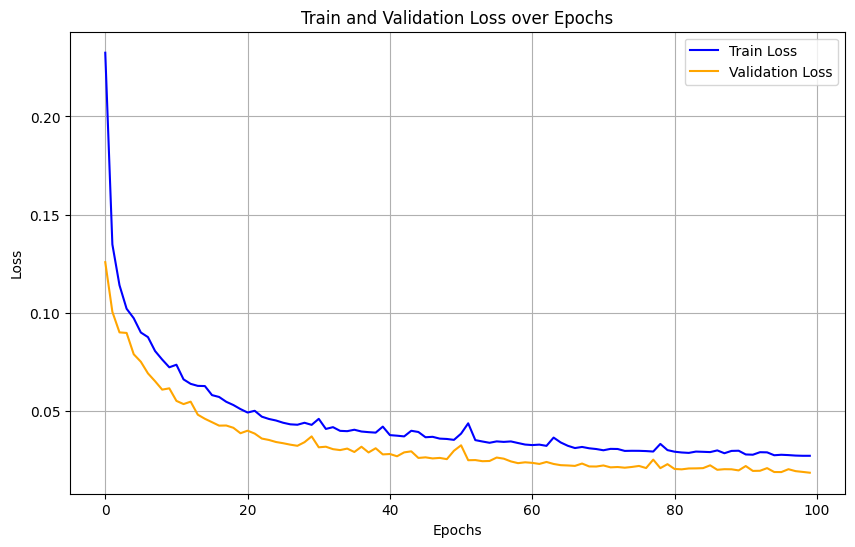

In [32]:
def build_model(input_shape):
    model = Sequential()
    
    # Tăng số đơn vị LSTM và giảm regularization
    model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True, 
                   kernel_regularizer=l2(0.0005)))
    model.add(LSTM(units=64, kernel_regularizer=l2(0.0005)))
    
    # Giảm Dropout
    model.add(Dropout(0.1))
    
    # Lớp Dense để đưa ra kết quả dự đoán
    model.add(Dense(1))
    
    # Compile mô hình
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0005))
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])
model = build_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/TPB_model_adjusted.keras"

# Callbacks: ModelCheckpoint, EarlyStopping và ReduceLROnPlateau
callbacks = [
    ModelCheckpoint(save_model_path, monitor='val_loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=2)
]

# Huấn luyện mô hình
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=128,  # Thay đổi batch size
    verbose=2,
    callbacks=callbacks
)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
save_model_path = "models/TPB_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [14]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


In [15]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


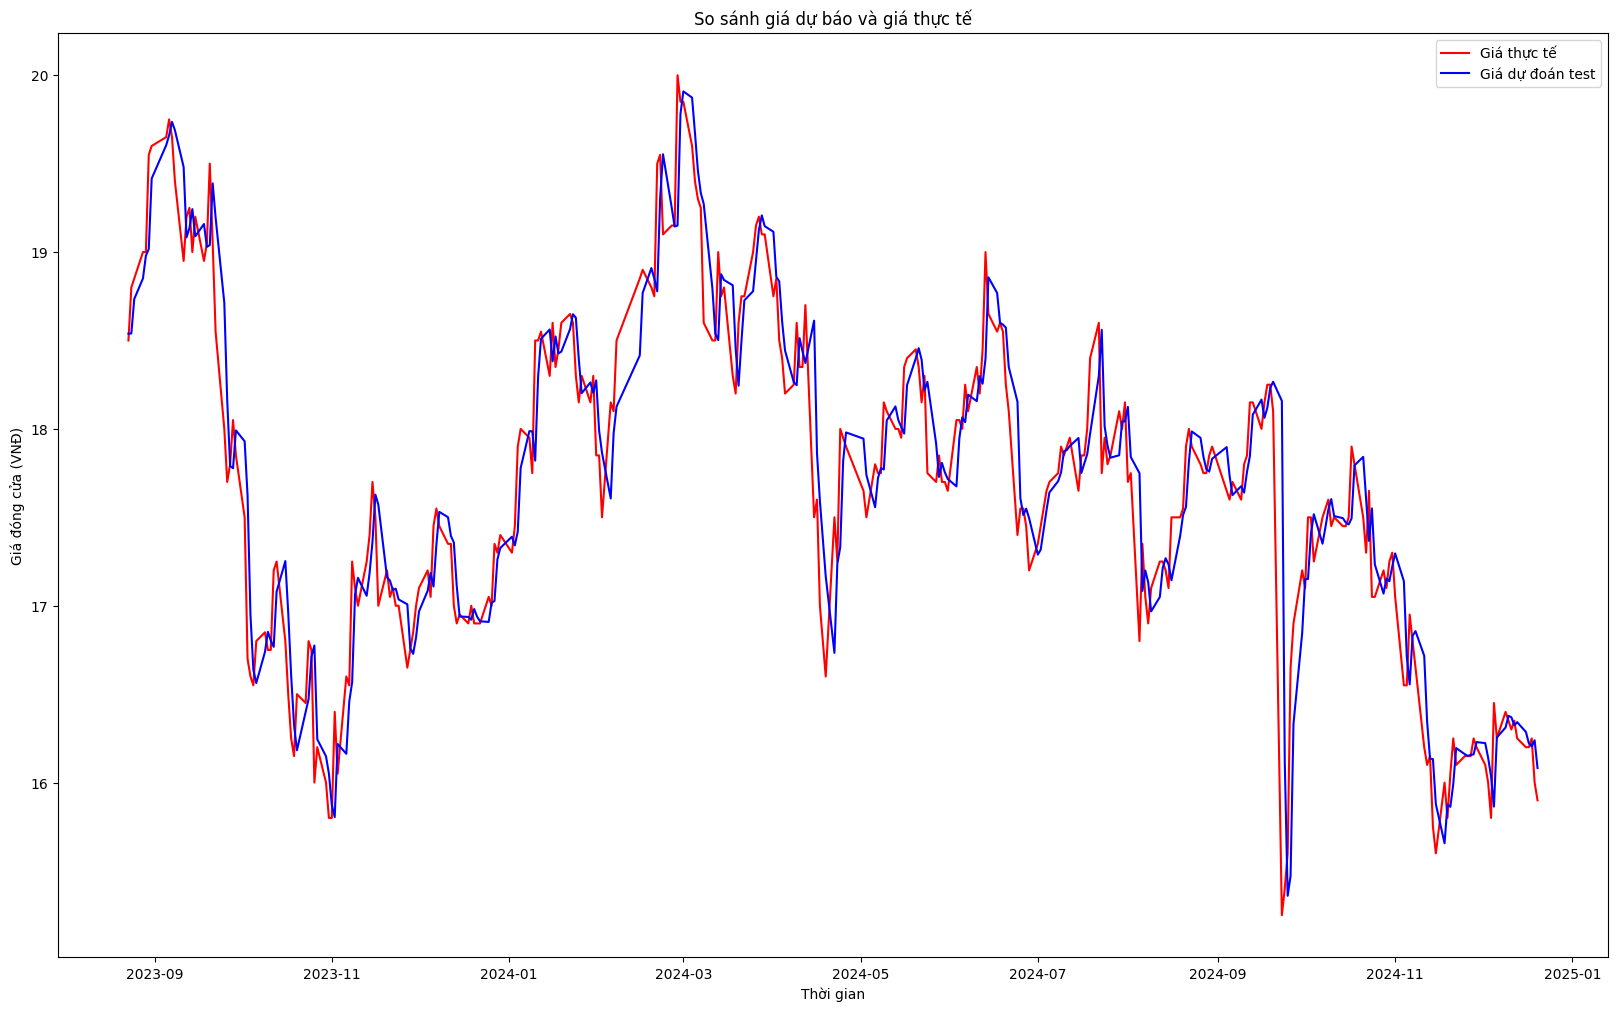

In [16]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [17]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9883729392988084
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.44840020740078584
Phần trăm sai số tuyệt đối trung bình trên tập train: 1.6139219635179503
RMSE trên tập train (VNĐ): 0.7718294764583672
Độ chính xác trên tập train (%): 97.84405174173641
F1 Score trên tập train: 1.0
----------------------------------------------------


In [18]:
y_test = data[-len(y_test_predict):]

In [19]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.8805923369745021
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.21807518976177284
Phần trăm sai số tuyệt đối trung bình trên tập test: 1.246200926645933
RMSE trên tập test (VNĐ): 0.33061339290080427
Độ chính xác trên tập test (%): 93.03971804419359
F1 Score trên tập test: 1.0
----------------------------------------------------


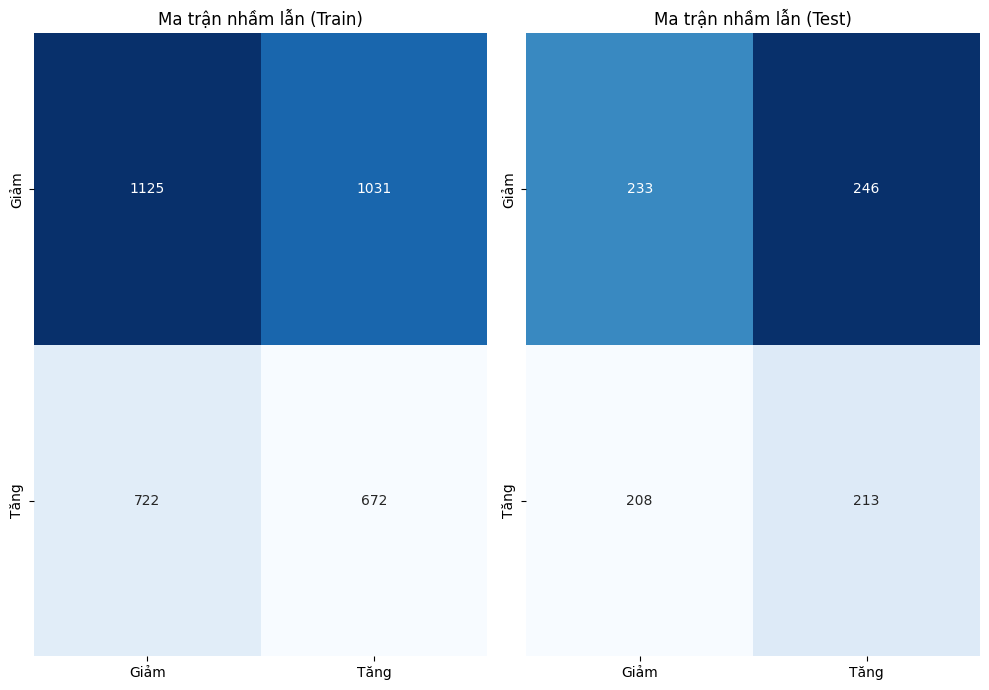

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_labels(data):
    return [1 if data[i] > data[i-1] else 0 for i in range(1, len(data))]

# Chuyển đổi giá trị thực tế và dự đoán thành nhãn phân loại
y_train_labels = create_labels(y_train)
y_train_predict_labels = create_labels(y_train_predict.flatten())

y_test_labels = create_labels(y_test)
y_test_predict_labels = create_labels(y_test_predict.flatten())

# Tạo ma trận nhầm lẫn cho tập train
cm_train = confusion_matrix(y_train_labels, y_train_predict_labels)
cm_test = confusion_matrix(y_test_labels, y_test_predict_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 7))

# Ma trận nhầm lẫn cho tập train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Train)")

# Ma trận nhầm lẫn cho tập test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Test)")

plt.tight_layout()
plt.show()